# Goals

This is a companion notebook to the paper `A tutorial on discriminative clustering`.  The goal of this notebook is to demonstrate different approaches to solve the same clustering problem. We demonstrate three different approaches:

1. Using linear decision boundaries, including
    + KMeans clustering
    + RIM
2. Using kernel or projection-based methods
    + Spectral clustering
    + Kernel RIM
3. Using neural networks as conditional distribution with maximisation of mutual information
4. Using neural networks as discriminative function with contrastive augmentations

# Setup

We start by loading a couple useful packages

## Packages

In [1]:
import numpy as np # Array handling
import gemclus # Discriminative models
from sklearn import cluster # More clustering models
from sklearn import datasets # Dataset generation
from sklearn import metrics # For evaluating performances
import sklearn
from matplotlib import pyplot as plt # Visualisation
import torch # For deep learning
from torch import nn # neural network components

In [2]:
print("Numpy version:", np.__version__)
print("Sklearn version:", sklearn.__version__)
print("GemClus version:", gemclus.__version__)
print("Torch version", torch.__version__)

Numpy version: 1.26.4
Sklearn version: 1.5.2
GemClus version: 1.0.0
Torch version 2.5.0+cpu


## Dataset

We then load a dataset consisting in two concentric circles.

In [3]:
# Create the dataset
X, y = datasets.make_circles(n_samples=200, noise=0.05, factor=0.1, random_state=0)

# Normalise the data
X = (X-X.mean(0))/X.std(0)

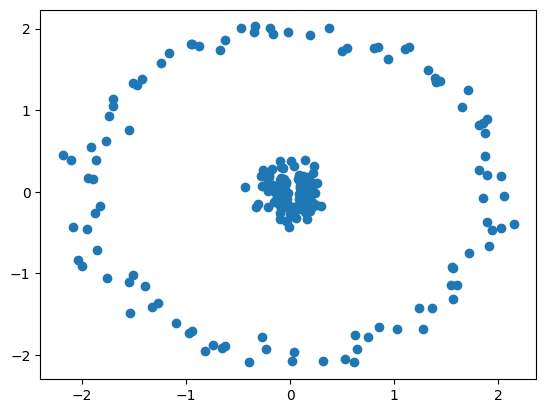

In [4]:
# Plot the data
plt.scatter(X[:,0], X[:,1])
plt.savefig("concentric_circles.pdf", bbox_inches="tight")
plt.show()

## Tools

We define here a convenient function to plot the decision boundary of a model. To that end, we simply generate a meshgrid covering the entire dataset and plot the prediction for each of the grid points

In [5]:
def plot_model(clustering, grid_predictions=None):
    """
    Plots the clustering result of a model, and its decision boundary
    if the model could predict for novel samples
    """
    if grid_predictions is not None:
        plt.contourf(xx, yy, grid_predictions, alpha=0.3, cmap="seismic")
    plt.scatter(X[:,0], X[:,1], c=clustering)
    plt.tight_layout()
    plt.axis("off")

In [6]:
# Create the meshgrid of inputs for decision boundary plotting
resolution = 50 # 50x50 samples
x_min, y_min = X.min(0)
x_max, y_max = X.max(0)
x_vals = np.linspace(x_min-0.5, x_max+0.5, num=resolution)
y_vals = np.linspace(y_min-0.5, y_max+0.5, num=resolution)
xx, yy = np.meshgrid(x_vals, y_vals)
grid_inputs = np.c_[xx.ravel(), yy.ravel()]

# Clustering

## Linear decision boundaries

We can now try to train different clustering models. For this very speficic dataset, the assumptions of KMeans regarding data distribution around a centroid will make it fail.

ARI of KMeans predictions: 0.174


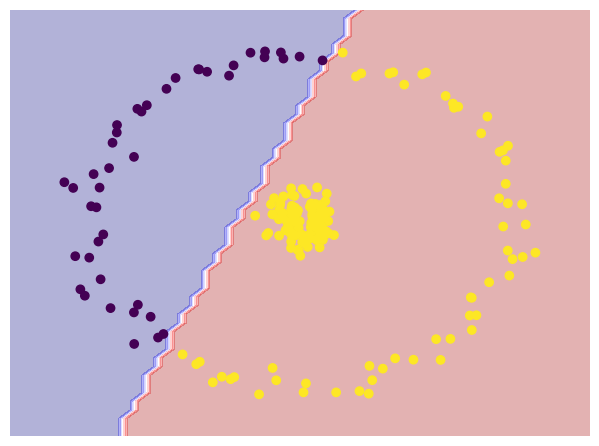

In [7]:
# Create a KMeans model
model = cluster.KMeans(n_clusters=2, random_state=0)
# Fit it to the data. Note the absence of paameter `y`in the fit function.
y_pred = model.fit_predict(X)
# Evaluate with the ARI the clustering performances with known targets.
score = metrics.adjusted_rand_score(y, y_pred)
print(f"ARI of KMeans predictions: {score:.3f}")

# Evaluate the decision boundary
grid_predictions = model.predict(grid_inputs).reshape((resolution, resolution))
plot_model(y_pred, grid_predictions)

An ARI of 0.174 is quite poor for such a dataset.

Now, let us compare with a model that will also draw a linear decision boundary: RIM. The key difference in the design here is that we do not think that clusters are centred around centroids, like in a KMeans, but are explicitly separated by a linear decision boundary. What was the consequence of KMeans is here the choice of design.

ARI of Linear RIM predictions: -0.003


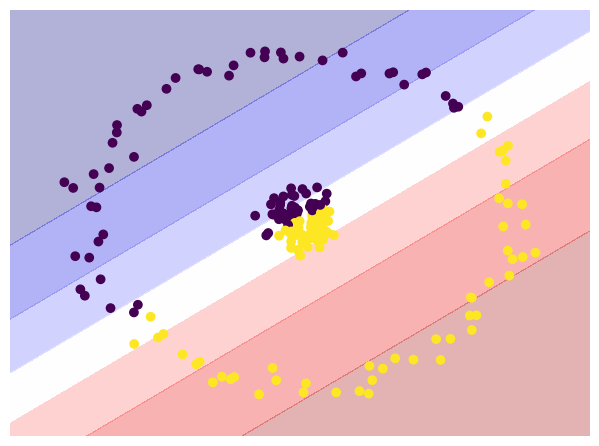

In [8]:
# Create a linear RIM clustering model
model = gemclus.linear.RIM(n_clusters=2, random_state=0)
# Fit it to the data
y_pred = model.fit_predict(X)
# Evaluate the ARI
score = metrics.adjusted_rand_score(y, y_pred)
print(f"ARI of Linear RIM predictions: {score:.3f}")

# Take a look at the decision boundary
grid_predictions = model.predict_proba(grid_inputs)[:,1].reshape((resolution, resolution))
plot_model(y_pred, grid_predictions)

Here, the ARI is lower because the mutual information objective implicitly required clusters to be balanced. By splitting the circles right in the middle, none of the proposed cluster is closer to the outer or the inner circle. Consequently, the ARI is 0: we are no better than randomly assigning clusters with 50% probability.

## Using projections

It seems clear that the circles cannot be separated using a straight line. Instead, we can seek to project the data into a different space where we will draw a decision boundary.

Let us try first with spectral clustering.

ARI of Spectral predictions: 1.000


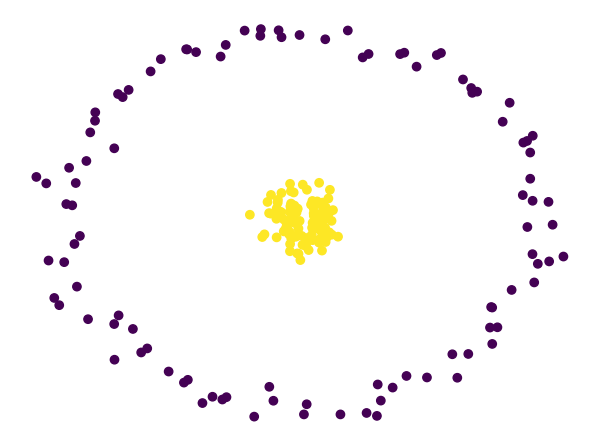

In [9]:
# Create a spectral clustering model
model = cluster.SpectralClustering(n_clusters=2)
# Fit it to the data
y_pred = model.fit_predict(X)
# Evaluate the ARI
score = metrics.adjusted_rand_score(y, y_pred)
print(f"ARI of Spectral predictions: {score:.3f}")

plot_model(y_pred)

Excellent, the spectral clustering model achieves the desired objective! However, spectral clustering lacks a quality which might be desirable: generalization. It is therefore impossible to visualise the decision boundary of this model.

Let us try now a different model: kernel RIM, i.e. logistic regression optimised with mutual information on a kernel matrix.

ARI of Kernel RIM predictions: 1.000


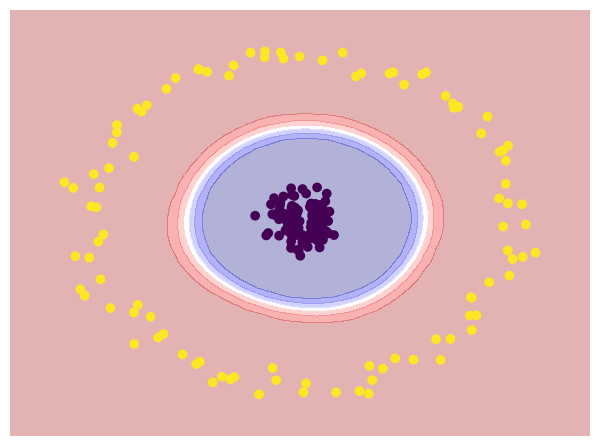

In [10]:
# Create a kernel RIM clustering model (no regularisation)
model = gemclus.linear.KernelRIM(n_clusters=2, base_kernel="rbf", reg=0, random_state=0)
# Fit it to the data
y_pred = model.fit_predict(X)
# Evaluate the ARI
score = metrics.adjusted_rand_score(y, y_pred)
print(f"ARI of Kernel RIM predictions: {score:.3f}")

grid_predictions = model.predict_proba(grid_inputs)[:,1].reshape((resolution, resolution))
plot_model(y_pred, grid_predictions)

This model fully satisfies our needs: the ARI is 1, and we have the exact decision boundary we wish for. Nonetheless, there is a slight limitation in this kernel model: the generalisation is linearly dependent on the number of samples in the dataset. While this is not a problem for such a small dataset, it may be challenging for large datasets.

To ensure generalisation that scales no matter the dataset size, we can take a look at neural networks for discriminative clustering.

## Neural networks as conditional distributions

Here, we model our conditional distribution $p_\theta(y\mid \pmb{x})$ using a neural network. We use a 2-layer neural network. The first layer will draw boundary between the inner and outer circles while the second layer will choose which part goes to which cluster. To train the model, we can begin by using the mutual information.

ARI of MLP MI predictions: 0.278


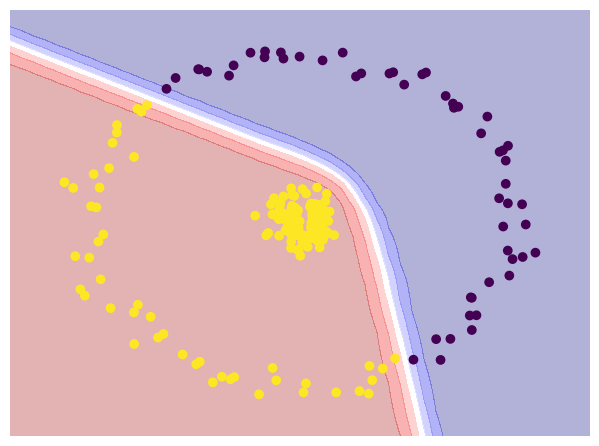

In [11]:
# Create an MLP for clustering
model = gemclus.mlp.MLPModel(n_clusters=2, gemini="mi", n_hidden_dim=20, random_state=0)
# Fit it to the data
y_pred = model.fit_predict(X)
# Evaluate the ARI
score = metrics.adjusted_rand_score(y, y_pred)
print(f"ARI of MLP MI predictions: {score:.3f}")

grid_predictions = model.predict_proba(grid_inputs)[:,1].reshape((resolution, resolution))
plot_model(y_pred, grid_predictions)

What happened above is that in the absence of regularisation on mutual information, any decision boundary that partitions the dataset evenly will be sufficient. That is why there exist other methods to regularise MI in such a case. For instance, GEMINI:

ARI of MLP MMD-GEMINI predictions: 1.000


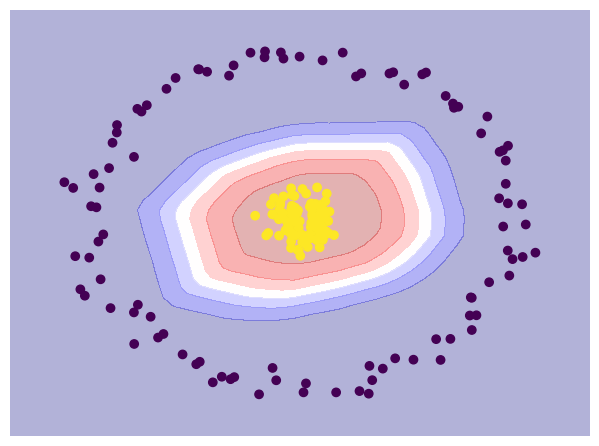

In [12]:
# Train the model using GEMINI, which regularises MI using distances
model = gemclus.mlp.MLPMMD(n_clusters=2, n_hidden_dim=20, kernel="rbf", random_state=0)
# Fit it to the data
y_pred = model.fit_predict(X)
# Evaluate the ARI
score = metrics.adjusted_rand_score(y, y_pred)
print(f"ARI of MLP MMD-GEMINI predictions: {score:.3f}")

grid_predictions = model.predict_proba(grid_inputs)[:,1].reshape((resolution, resolution))
plot_model(y_pred, grid_predictions)

Beyond clustering the dataset we have here, some of these models generalise. This means that they can cluster novel samples. Thanks to this property, we can observe the decision boundary of these clustering models.

## Clustering with contrastive learning

For the sake of the complete example, we now how to perform clustering using contrastive learning. This involves however a change of philosophy. We will use the same neural network, but its role will not be to cluster. Instead, this model will attempt at discriminative samples and their respective augmentation against any other sample. To that end, we need an augmentation strategy.

We will try two different augmentations:
+ Adding Gaussian noise
+ Randomly rotating the dataset

To be compatible with the contrastive loss, our model is part of a similarity function. We will use the cosine similarity. This implies that we need to normalise the outputs of the models. To further show that we do not model any conditional distribution, we remove the softmax at the end of the neural network.

In [13]:
# Let us define the Info NCE loss

def info_nce(y_original, y_augmented):
    # First, we normalise the predictions to be able to use the cosine similarity
    y_original = y_original / torch.norm(y_original, p=2, dim=1, keepdim=True)
    y_augmented = y_augmented / torch.norm(y_augmented, p=2, dim=1, keepdim=True)

    # We then compute the similarity between all pairs of samples
    similarities = y_original@y_augmented.T

    return -torch.diag(torch.softmax(similarities, dim=1))

### Random Gaussian noise

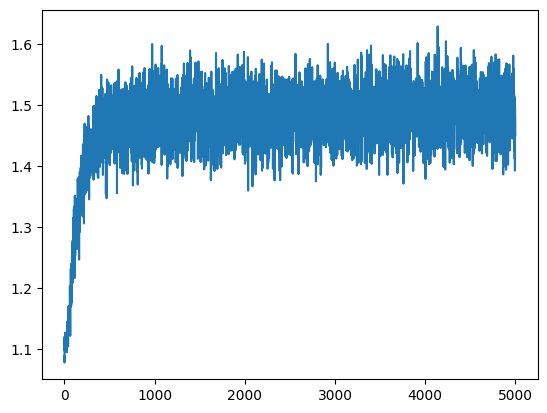

In [14]:
torch.manual_seed(0)

# Create the model
model = nn.Sequential(
    nn.Linear(X.shape[1], 20),
    nn.ReLU(),
    nn.Linear(20, 2) # Notice the absence of softmax
)

optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)

X_torch = torch.Tensor(X)

loss_history = []

for i in range(5000): # 5000 epochs
    # Augment with random Gaussian noise
    augmented_samples = X_torch + torch.normal(0, 1, X_torch.shape)

    original_prediction = model(X_torch)
    with torch.no_grad():
        augmented_prediction = model(augmented_samples)

    loss = info_nce(original_prediction, augmented_prediction).sum()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    loss_history += [-loss.item()]

# Let us visualise the loss history
plt.plot(loss_history)

We can now observe the decision boundary and the prediction of this model on our dataset.

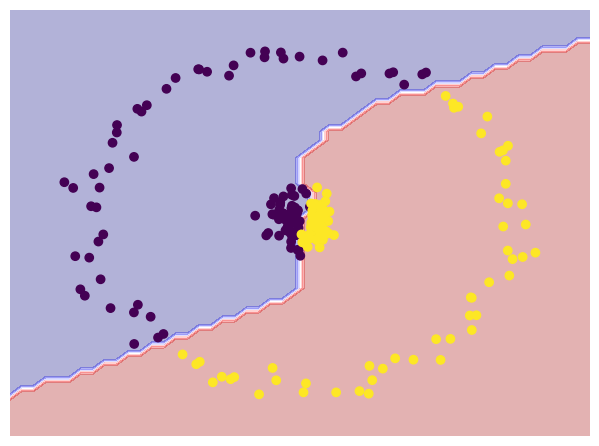

In [15]:
with torch.no_grad():
    y_pred = model(X_torch).argmax(1)
    grid_predictions = model(torch.Tensor(grid_inputs)).argmax(1).reshape((resolution, resolution))
plot_model(y_pred, grid_predictions)

Here, the augmentation was problematic because the scale of the noise was too big. This led the augmentation of samples to cover almost any other from the dataset, independently of the source class. We can try to voercome this problem by lowering the scale.

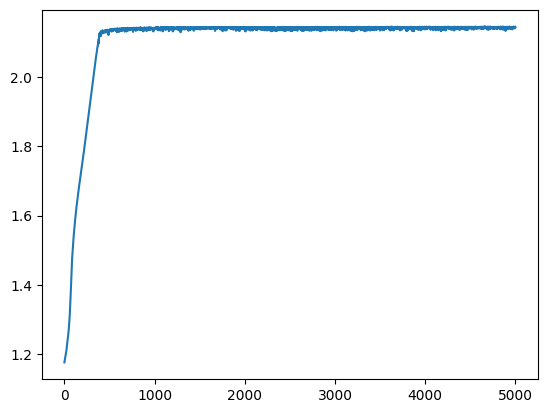

In [16]:
# Same code as before, only the scale changed!
torch.manual_seed(0)

# Create the model
model = nn.Sequential(
    nn.Linear(X.shape[1], 20),
    nn.ReLU(),
    nn.Linear(20, 2) # Notice the absence of softmax
)

optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)

X_torch = torch.Tensor(X)

loss_history = []

for i in range(5000): # 5000 epochs
    # Augment with random Gaussian noise
    augmented_samples = X_torch + torch.normal(0, 0.01, X_torch.shape)

    original_prediction = model(X_torch)
    with torch.no_grad():
        augmented_prediction = model(augmented_samples)

    loss = info_nce(original_prediction, augmented_prediction).sum()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    loss_history += [-loss.item()]

# Let us visualise the loss history
plt.plot(loss_history)

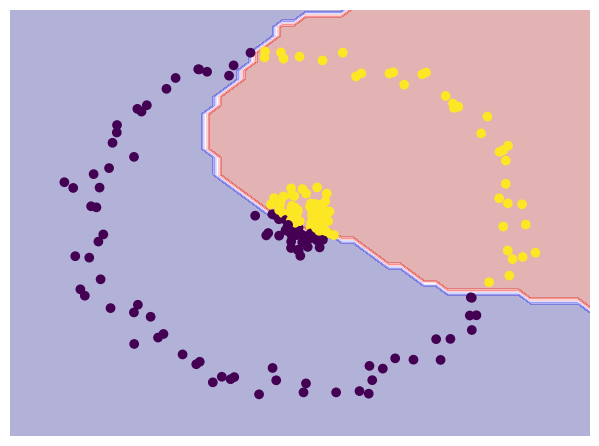

In [17]:
with torch.no_grad():
    y_pred = model(X_torch).argmax(1)
    grid_predictions = model(torch.Tensor(grid_inputs)).argmax(1).reshape((resolution, resolution))
plot_model(y_pred, grid_predictions)

So adding just random Gaussian noise seem to not suffice for learning this dataset in a contrastive fashion.

### Random rotation

Instead of adding Gaussian noise, we can rotate the dataset by a random angle between 0 and $2\pi$. Indeed, we expect our circles to be invariant to rotation!

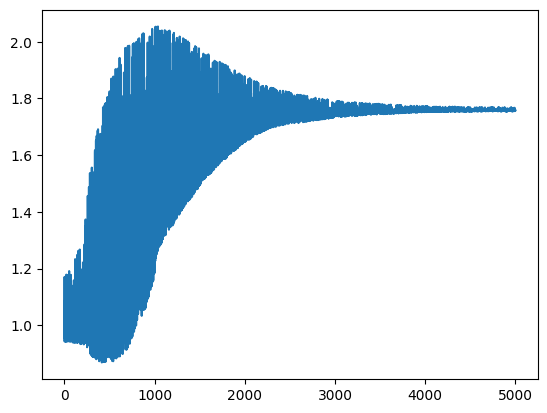

In [18]:
# Same code as before, only the scale changed!
torch.manual_seed(0)

# Create the model
model = nn.Sequential(
    nn.Linear(X.shape[1], 20),
    nn.ReLU(),
    nn.Linear(20, 2) # Notice the absence of softmax
)

optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)

X_torch = torch.Tensor(X)

loss_history = []

for i in range(5000): # 5000 epochs
    # Augment with a randomly chosen angle
    theta = 2*torch.pi*torch.rand(1)
    rot_matrix = torch.Tensor([[torch.cos(theta), -torch.sin(theta)],[torch.sin(theta), torch.cos(theta)]])
    augmented_samples = X_torch@rot_matrix.T

    original_prediction = model(X_torch)
    with torch.no_grad():
        augmented_prediction = model(augmented_samples)

    loss = info_nce(original_prediction, augmented_prediction).sum()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    loss_history += [-loss.item()]

# Let us visualise the loss history
plt.plot(loss_history)

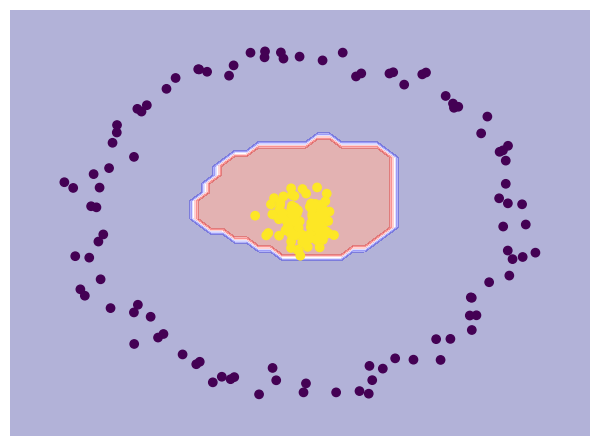

In [19]:
with torch.no_grad():
    y_pred = model(X_torch).argmax(1)
    grid_predictions = model(torch.Tensor(grid_inputs)).argmax(1).reshape((resolution, resolution))
plot_model(y_pred, grid_predictions)

# Summary

We explored in this notebook different approaches to tackling a simple dataset using discriminative clustering techniques. We notably presented how our reflection and knowledge on the dataset (our prior in a sense) led us to choose better discriminative hypothesis for separating the circle, using kernel-based methods, neural networks and contrastive losses.